Cahier IPython en cours d'élaboration....

    v1.0 2019/06/13 BA  MAJ par Benjamin AILLOUD (stage L2 informatique)    

In [11]:
%matplotlib inline

# Machine Learning : Réseau de neurone convolutionnel

<p style="text-align:center; font-style:italic; font-size=xx-small">
    <img src="./figures/cnn_doc.png" width="600" >
    (crédit image : JLC)
</p>

# Prérequis

L'objectif de ce tp est de comprendre le fonctionnement d'un `réseau convolutionnel` et sa construction via l'utilisation des modules `keras` et `tensorflow`. Programmer un `réseau convolutionnel` ne diffère pas entièrement d'un `réseau dense` vu au tp précédent, le déroulement du code reste essentiellement le même : 
- Import des images
- Ici, les images ne sont plus vectorisées car l'opération de convolution nécessite une matrice de pixels, mais il y'a quand même une étape de transformation des données d'entrées pour rajouter les canaux de couleurs. L'étape de normalisation est toujours importante.
- `Hot encoding` des output
- Construction du modèle
- Entrainement
- Analyse des résultats

Petit rappel de cours: 
- Chaque étape de `convolution` comporte aussi une `activation` qui utilise généralement la fonction `relu`
- Un réseau de neuronne convolutionnel se termine par une couche dense

# Formatage des données


In [2]:
import tensorflow  
import keras 

# Load data from https://www.openml.org/d/554
from keras.datasets import mnist
(image_train, etiq_train), (image_test, etiq_test) = mnist.load_data()
print(type(image_train),type(image_test))
print(type(etiq_train),type(etiq_test))

Using TensorFlow backend.


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [3]:
import numpy as np
from keras.utils import np_utils 

# Normalisation des valeurs de pixel
image_train = image_train/255
image_test = image_test/255

y_train = np_utils.to_categorical(etiq_train)
y_test  = np_utils.to_categorical(etiq_test)

L'utilisation des réseaux de convolution nécessite des `inputs` prenant en compte le nombre de `canaux de couleur`, par exemple, une image RGB possède 3 canaux de couleurs alors qu'une image en noir et blanc n'en possède qu'un.
Pour l'instant nos inputs sont en format 2 dimensions où le canal de couleur n'est pas représenté.

In [4]:
print(image_train.shape)

(60000, 28, 28)


**60 000 images 2D de 28x28** pixels,<span style="color:blue;font-family:arial"> rajoutons la dimension du 'canal gris', en sachant que nos images sont en </span> **ton de gris**.

In [5]:
image_train = image_train.reshape((60000,28,28,1))
image_test = image_test.reshape((10000,28,28,1))

# Création du modèle


<span style="color:blue;font-family:arial"> Cette fois-ci, c'est à vous de créer le **modèle** représenté dans l'image de début de tp, en utilisant notamment la librairie `tensorflow`. Pour créer les couches vous allez devoir utiliser les fonctions du module `tensorflow.keras.layers`, lisez bien la doc et la description des arguments des fonctions: </span>
- **Conv2D**: `Première convolution`(16 filtres, fenêtre(5,5), activation('relu'),input((28,28,1)), `Seconde convolution`(32 filtres, fenêtre(5,5), activation('relu')
- **MaxPooling2D** //args : Facteur de division des matrices en largeur et hauteur(2,2)
- **Dense** //args : Nombre de neuronne dans la couche = largeur output * hauteur output * nombre d'output de la couche précédente. <br> </br> Prendre en compte le pooling pour la taille des input !  
- **Flatten**



<span style="color:blue;font-family:arial"> Utiliser les infos précédentes pour donner les valeurs des paramètres du modèle : </span>

In [6]:
#Layer 1
nb_filters_layer_conv1 = 16
act_conv1 = 'relu'
kernel_size_conv1 = (5,5)
input_shape_conv = (28,28,1)
pool_ratio_conv1 = (2,2)

#Layer2
nb_filters_layer_conv2 = 32
act_conv2 = 'relu'
kernel_size_conv2 = (5,5)
pool_ratio_conv2 = (2,2)

#Layer 3
input_size = input_shape_conv[0]/pool_ratio_conv1[0]/pool_ratio_conv2[0]
nb_neurons_dense1 = input_size * input_size * nb_filters_layer_conv2 
act_dense1 = 'relu'
kernel_init_dense1 = 'normal'

#Layer 4
nb_neurons_dense2 = y_test.shape[1] 
act_dense2 = 'softmax'
kernel_init_dense2 = 'normal'

dropout_ratio = 0.2

<span style="color:blue;font-family:arial"> Remplir le modèle :</span>

In [7]:
model = tensorflow.keras.models.Sequential()


#Première couche convolutionnelle correspondant à la couche d'entrée (input layer)  : 16 filtres, fenêtre(5,5)
model.add(tensorflow.keras.layers.Conv2D(filters = nb_filters_layer_conv1,
                                   kernel_size= kernel_size_conv1,
                                   activation= act_conv1,
                                   input_shape = input_shape_conv))

model.add(tensorflow.keras.layers.MaxPooling2D(pool_size= pool_ratio_conv1))

#Seconde couche convolutionnelle : 32 filtres, fenêtre(5,5)
model.add(tensorflow.keras.layers.Conv2D(filters = nb_filters_layer_conv2,
                                   kernel_size = kernel_size_conv2, 
                                   activation= act_conv2))

model.add(tensorflow.keras.layers.MaxPooling2D(pool_size= pool_ratio_conv2))

#Vectorisation des matrices
model.add(tensorflow.keras.layers.Flatten())

#Couche dense, le nombre de neuronnes vaut en général : nombre de filtres de la couche convolutionnelle précédente
# multipliée par la taille de celles-ci --> nbF * hauteur * largeur
# nb_neurons = nb_filters* * *...
model.add(tensorflow.keras.layers.Dense( nb_neurons_dense1,activation= act_dense1,kernel_initializer= kernel_init_dense1)) 

#La fonction Dropout permet de désactiver certains neuronnes avec la probabilité définie ce qui permet d'éviter le 
#sur-apprentissage des neuronnes aussi appelé "overfitting"
model.add(tensorflow.keras.layers.Dropout(dropout_ratio))


#Couche dense de sortie (output layer)
model.add(tensorflow.keras.layers.Dense(nb_neurons_dense2,activation = act_dense2,kernel_initializer= kernel_init_dense2))

model.compile(loss = "categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Entrainement du modèle


In [8]:
# Pour vous faire gagner du temps car l'entrainement d'un réseau convolutionnel est bien plus long, on limitera
# le paramètre `epochs` à une valeur faible (5 à 10 par exemple).

history = model.fit(image_train, y_train, validation_data=(image_test, y_test), epochs=5, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 26s 427us/sample - loss: 0.1526 - acc: 0.9544 - val_loss: 0.0438 - val_acc: 0.9850
Epoch 2/5
60000/60000 [==============================] - 25s 421us/sample - loss: 0.0451 - acc: 0.9861 - val_loss: 0.0337 - val_acc: 0.9891
Epoch 3/5
60000/60000 [==============================] - 23s 383us/sample - loss: 0.0314 - acc: 0.9902 - val_loss: 0.0275 - val_acc: 0.9900
Epoch 4/5
60000/60000 [==============================] - 29s 475us/sample - loss: 0.0237 - acc: 0.9927 - val_loss: 0.0284 - val_acc: 0.9913
Epoch 5/5
60000/60000 [==============================] - 23s 388us/sample - loss: 0.0181 - acc: 0.9944 - val_loss: 0.0303 - val_acc: 0.9907


# Analyse des résultats

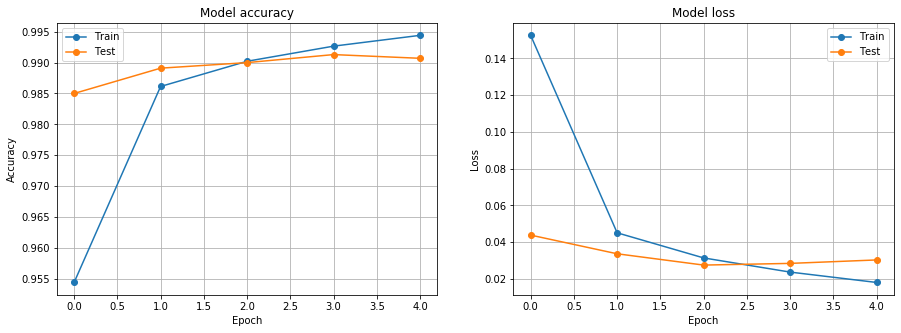

In [13]:
def plot(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(15,5))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(history.history['acc'], 'o-',label='Train')
    ax1.plot(history.history['val_acc'], 'o-', label='Test')
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch') 
    ax1.grid()
    ax1.legend(loc='best')
    # Plot training & validation loss values
    ax2 = plt.subplot(1,2,2)
    ax2.plot(history.history['loss'], 'o-', label='Train')
    ax2.plot(history.history['val_loss'], 'o-',  label='Test')
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='best')
    ax2.grid()
    plt.show()

plot(history)    

In [14]:
res = model.predict_on_batch(image_test)

rep = 0
for i in range(len(image_test)):
    rep += np.argmax(res[i]) == etiq_test[i]
print("taux de réussite : {:.2f} %".format(rep/len(image_test)*100))


#ou
model.test_on_batch(image_test, y_test)

taux de réussite : 99.07 %


[0.030303387, 0.9907]

**Si votre modèle est bon, vous devriez obtenir un taux de réussite aux alentours de 99% voir plus.
Rappel : Le taux de réussite peut s'améliorer en augmentant le nombre d'epochs**

# Utilisons nos images de la dernière fois pour voir ci ce réseau est plus efficace

In [28]:
import os
images = ['./chiffres/'+f for f in os.listdir('./chiffres') if f.endswith(".png") or f.endswith(".jpg")]
print("Liste des images envoyées : {}".format(images))

Liste des images envoyées : ['./chiffres/huit.png', "./chiffres/ce n'est pas un deux.png", './chiffres/septFrançais.png', './chiffres/6jlc.png', './chiffres/essa1.png', './chiffres/quatre.png', "./chiffres/n'oeuf.png", './chiffres/cinq.png', './chiffres/chaval de 3.png', './chiffres/septAmericain.png']


In [29]:
import cv2
# lecture des images -> matrices ndarray 28x28 
input_data = [255-cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2GRAY) for image in images]
input_data = np.array(input_data)
input_data.shape, input_data.dtype  # on doit avoir 4 matrices de 28 x 28 valeurs

((10, 28, 28), dtype('uint8'))

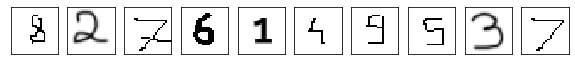

In [30]:
plt.figure(figsize=(10,10))
for i,M in enumerate(input_data):  
    plt.subplot(1,input_data.shape[0],i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(input_data[i], cmap='binary')
plt.show()    

In [31]:
nb_images = input_data.shape[0]
# mise 'à plat' des matrices sous forme de vecteurs de floats :
X_photo = input_data.reshape(nb_images, 28,28,1).astype('float32')
# normalisation des données :
X_photo /= 255

In [32]:
rep = model.predict(X_photo)
with np.printoptions(formatter={'float': '{:0.4f}'.format}): print(rep)

[[0.0009 0.0003 0.0155 0.0010 0.0008 0.0006 0.0034 0.0000 0.9737 0.0038]
 [0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0137 0.0000 0.0000 0.0000 0.0000 0.9862 0.0000 0.0000]
 [0.0002 0.0000 0.0000 0.0000 0.0000 0.0495 0.9502 0.0000 0.0001 0.0001]
 [0.0000 0.9810 0.0136 0.0001 0.0018 0.0000 0.0000 0.0034 0.0000 0.0001]
 [0.0000 0.0000 0.0002 0.0001 0.9739 0.0252 0.0000 0.0001 0.0001 0.0003]
 [0.0007 0.0019 0.0154 0.0023 0.0172 0.0051 0.0000 0.0030 0.0020 0.9523]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.9933 0.0000 0.0000 0.0000 0.0067]
 [0.0000 0.0000 0.0000 0.9999 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0001 0.0000 0.0000 0.0000 0.0000 0.9999 0.0000 0.0000]]


In [33]:
[r.argmax() for r in model.predict(X_photo)]

[8, 2, 7, 6, 1, 4, 9, 5, 3, 7]

**On peut voir que le réseau convolutionel n'est pas à 100% fiable mais il permet quand même de très bon résultats comparé au réseau dense vu précédemment.**